# Agent-Based Model - General Paz

## Descripción del modelo

### Objetivo

Nuestro objetivo es implementar una simulación realista de la Avenida General Paz. En los tramos de Liniers a Lugones. 

### Entidades / Agentes

Las entidades del modelo, qué serán los qué circulen por él, en nuestro modelo corresponden a los automóviles con sus respectivos conductores. Los agentes son autónomos, es decir, están dotados con comportamientos que les permiten tomar decisiones independientes.

### Atributos

Las entidades tienen distintos atributos que lo describen como:

- Posición **(x)**.
- Velocidad **(v)**.
- Velocidad máxima del vehículo **(vmax)**.
- Longitud del auto. **(l)**.
- Aceleración y desaceleración (cuanto tarda el vehículo en promedio en llegar de 0 a 80 y de 80 a 0 km/h) **(a)**.
- Tiempo de permanencia en la autopista **(t)**.
- Tiempo de reacción de frenado. **(tr)**

##### Interacción con otros agentes
Cada agente tiene un vehiculo por detras y por delante. Del vehiculo de adelante dependerá si el agente frena o no. Las reducciones de velocidad son las que causarán los *shockwaves*. 

- Distancia entre vehículo de atras **(bd)**.
- Distancia entre vehiculo de adelante **(fd)**. 

##### Comportamiento
- Los agentes reaccionan (mantienen su velocidad, aceleran y desaceleran) dependiendo de el ambiente y su vecindario. 
- Un agente podrá acelerar/desacelerar si el auto de adelante se lo permite. 
- Dependiendo de el comportamiento del agente que maneje el vehiculo, el mismo:
  -  respetará los limites de velocidad o no.
  -   tendrá mas o menos probabilidad de choque.


### Ambiente

El ambiente de nuestro agent-based transportation model será la infraestructura y capacidades de los nodos y enlaces de la red vial. Estas capacidades crean efectos de congestión (velocidades de viaje reducidas) limitando el número de agentes que se desplazan a través de la red de transporte en un momento dado.

### Variables de Decisión

Las variables de decisión son las qué generarán distintas alternativas o escenarios en el modelo. Es decir, estas serán las qué ayudarán a determinar cuál es el layout óptimo para la solución.
- Agregar peaje o no
- Agregar semáforos y cuantos.
- Agregar cámaras de fotomultas y cuantas.

### Variables de Referencia:  

Las variables de referencia son las obtenidas cómo resultado de la simulación. Se buscará mejorarlas en función al objetivo.
Tiempo promedio de recorrido de los vehículos.

### Variables de Estado

Las variables de estado son aquellas qué contienen la información necesaria para describir la situación actual de los recursos.
- Tasa de Ocupación en las principales zonas de aglomeración.
- Tasa de ocupación ocasionada por accidentes, vehículos detenidos, obras en la ruta, policías parando, etc.
- Tasa de ocupación ocasionada por mal tiempo.
- Tasa de ocupación del peaje o semáforos  (si es que se agregan).

### Recursos

- Los recursos utilizados en el modelo son:
- Las cámaras
- Los peajes 
- Los carteles de velocidad / Avisos. 

## Simulación

In [4]:
import random 
from typing import Optional
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [5]:
class Agent:

    def __init__(
        self, 
        x:float,                                                #posición
        v:float,                                                #velocidad
        vmax:float,                                             #velocidad máxima
        l:float,                                                #longitud del vehiculo
        a:float,                                                #aceleración
        tr:float,                                               #tiempo de reacción
        c:random.choices(["estandar", "esporadico"], [0.8, 0.2])[0],  #comportamiento de el agente
        fa: Optional["Agent"] = None,                           #agente de adelante
        ba: Optional["Agent"] = None,                           #agente de atras
    ):
    
        self.t = 0
        self.x = x
        self.v = v
        self.vmax = vmax
        self.l = l
        self.a = a
        self.tr = tr
        self.c = c
        self.fa = fa
        self.ba = ba

    
    def __repr__(self): 
        return f"Agent(t={self.t}, x={self.x}, v={self.v}, vmax={self.vmax}, l={self.l}, a={self.a}, tr={self.tr}, c={self.c}, fa={self.fa}, ba={self.ba})"

    def __str__(self):
        return f"Agent(t={self.t}, x={self.x}, v={self.v}, vmax={self.vmax}, l={self.l}, a={self.a}, tr={self.tr}, c={self.c}, fa={self.fa}, ba={self.ba})"
    

    def dist_to_front_agent(self):
        if self.fa == None:
            return None

        else: #hay otro agente adelante
            return abs(self.x - self.fc.x - self.l)


    def dist_to_back_agent(self):
        if self.ba == None:
            return None

        else: #hay otro agent atras
            return abs(self.bc.x - self.x - self.bc.l)


    def acelerar(self):
        if self.dist_to_front_agent() is None or self.dist_to_front_agent() > 0:

            # si el conductor es "bueno" respetará la velocidad maxima
            if self.c == "estandar" and self.v < self.vmax:
                self.v = min(self.v + self.a, self.vmax)

            # si el conductor es "malo" podria no respetar la velocidad maxima por lo que le sumaremos a su velocidad un numero entre 0 y 30
            elif self.c == "esporadico":
                self.v = self.v + self.a + random.randint(-30, 30)

    def desacelerar(self):
        # si nos topamos con una reducción de velocidad del auto de adelante nuestro instinto hará que reduzcamos la velocidad.
        if self.fa is not None and self.v > self.dist_to_front_agent():

            #el agente debe reducir la velocidad porque sino chocará (la reducirá a la velocidad del de adelante)
            self.v = self.dist_to_front_agent()

    def avanzar(self):
        self.x = self.x + self.v
    
    def posicion(self):
        return self.x

    def actualizar(self):
        self.acelerar()
        self.desacelerar()
        self.avanzar()
        self.t += 1


In [39]:
class Road:
    
    def __init__(self, km:int):
        self.km = km
        self.agents = []
        self.t = 0

    def __repr__(self):
        return f"Road(km={self.km}, agents={self.agents}, t={self.t})"
    
    def agregar_agent(self, agent:Agent):
        #comienza al principio de la carretera
        #agregamos el agente a la lista de agentes
        self.agents.append(agent)
        #asignamos su front y su back car teniendo en cuenta la lista de self.agents
        if len(self.agents) > 1:
            agent.fa = self.agents[-2]
            self.agents[-2].ba = agent
        
    
    def actualizar(self):
        for agent in self.agents:
            agent.actualizar()

            #si el agente llega al final de la carretera lo eliminamos
            if agent.get_position() > self.km:
                self.agents.remove(agent)

            #asignamos el front y back car de los agentes extremos de la lista
            if len(self.agents) > 0:
                self.agents[0].fa = None

        self.t += 1

        
    
    def plot(self):
        fig, ax = plt.subplots()
        ax.plot([agent.x for agent in self.agents], [0 for agent in self.agents], "o")
        ax.set_xlim(0, self.km)
        ax.set_ylim(-1, 1)
        ax.set_yticks([])
        ax.set_xlabel("Position")
        ax.set_title("Highway")
        ax.legend()
        
        plt.show()
    


No handles with labels found to put in legend.


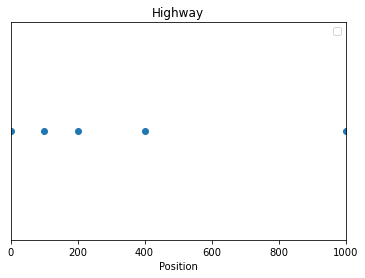

In [41]:
agp = Road(km = 1000)

agp.agregar_agent(Agent(x=0, v=0, vmax=120, l=5, a=2,tr=1, c="esporadico", fa=None, ba=None  ))
agp.agregar_agent(Agent(x=100, v=0, vmax=120, l=5, a=2,tr=1, c="estandar", fa=None, ba=None  ))
agp.agregar_agent(Agent(x=200, v=0, vmax=120, l=5, a=2,tr=1, c="estandar", fa=None, ba=None  ))
agp.agregar_agent(Agent(x=400, v=0, vmax=120, l=5, a=2,tr=1, c="estandar", fa=None, ba=None  ))
agp.agregar_agent(Agent(x=1000,v=0, vmax=120, l=5, a=2,tr=1, c="esporadico", fa=None, ba=None  ))

agp.plot()
